In [1]:
import sys
sys.path.append('/Users/pradap/Documents/Research/Python-Package/scaling/dmagellan/')

In [2]:
from dmagellan.blocker.attrequivalence.attr_equiv_blocker import AttrEquivalenceBlocker
from dmagellan.blocker.overlap.overlapblocker import OverlapBlocker
from dmagellan.blocker.blackbox.blackbox_blocker import BlackBoxBlocker
from dmagellan.blocker.rulebased.rule_based_blocker import RuleBasedBlocker
from dmagellan.feature.autofeaturegen import get_features_for_blocking

In [3]:
# imports
import py_entitymatching as em
from dask.sharedict import ShareDict, merge
from dask.dot import dot_graph

from dmagellan.optimization.dictutils import *
from dmagellan.optimization.blocker_sequence_opt import *

from dmagellan.utils.py_utils.sample_fns import test_create_dag

from dask.optimize import *


In [4]:
b_dag = test_create_dag()
dag = dict(b_dag.dask)

Reading the files done


In [5]:
def delay_concat(dag, start='_block_table_part', search='concat_df', copy=False):
    if isinstance(dag, dict):
        blocker_list = get_blocker_subgraphs_ordered(dag, start, search)
    else:
        blocker_list = dag
    blocker_list = remove_concat_split_for_blocker_list(blocker_list)
    out_dag = dict(convert_ldicts_to_sdict(blocker_list))
    return out_dag

In [8]:
# update the input tables
def update_input_tables(dag, copy=False):
    if copy:
        dag = deepcopy(dag)

    for head in get_keys(dag, '_block_table_part'):
        h_ltbl, h_rtbl = dag[head][1], dag[head][2]
        dag = set_ltable_rtable_for_cand_deps(dag, head, h_ltbl, h_rtbl)
    return dag


In [12]:
def fuse_dag(dag, copy=False):
#     d =dict(convert_ldicts_to_sdict(c_blocker_list))
    if copy:
        dag = deepcopy(dag)
    dag = dict(dag)
    dsk, dep = cull(dag, dag.keys())
    dsk, dep = fuse(dsk, ave_width=2, rename_keys=False)
    return dsk
    

In [15]:
#opt_1
opt1 = rearrange_blockers(dag)

# opt1_1 - case 1
opt11_c1 = move_addid(opt1)
opt11_c2 = move_addid(dag)

# opt-2 remove concats
opt2_c1 = delay_concat(opt11_c1)
opt2_c2 = delay_concat(opt11_c2)
opt2_c3 = delay_concat(opt1)
opt2_c4 = delay_concat(dag)


# opt-21 update input tables
opt21_c1 = update_input_tables(opt2_c1)
opt21_c2 = update_input_tables(opt2_c2)

# opt-3 fuse
opt3 = fuse_dag(opt21_c1, copy=True)









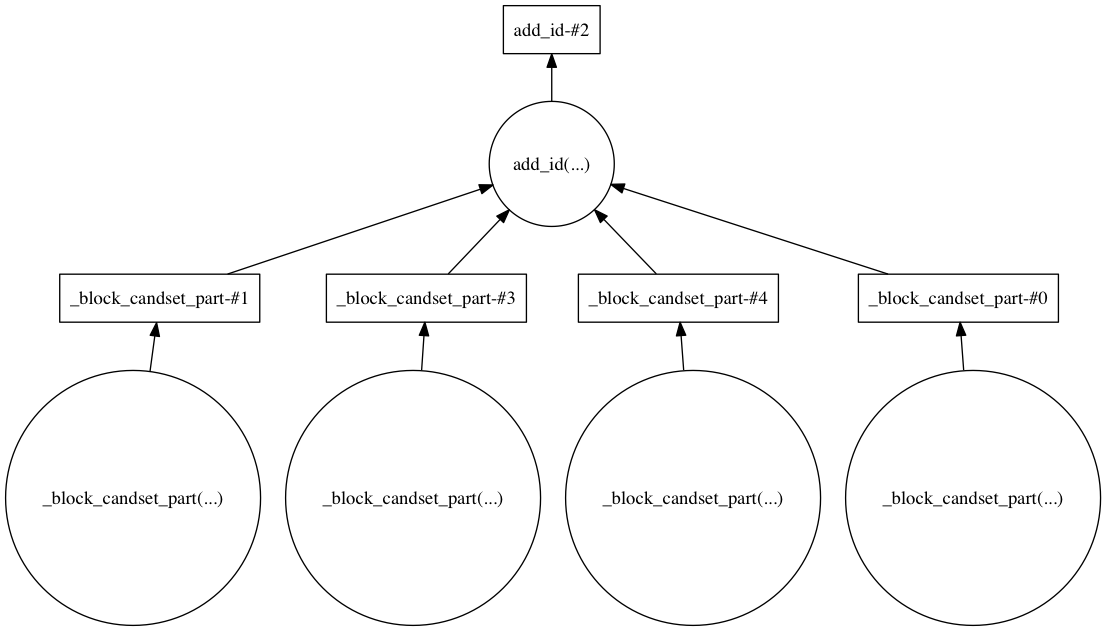

In [14]:
dot_graph(opt3)

In [18]:
comp_fuse(b_dag, [opt3], [opt21_c1])

,_id,l_ID,r_ID,l_name,l_address,l_zipcode,r_name,r_address,r_zipcode
0,0,1,2,Michael Franklin,"1652 Stockton St, San Francisco",94122,Mike Franklin,"1652 Stockton St, San Francisco",94122
1,1,2,1,William Bridge,"3131 Webster St, San Francisco",94107,Bill Bridge,"3131 Webster St, San Francisco",94107
2,2,4,4,Alphonse Kemper,"1702 Post Street, San Francisco",94122,Alfons Kemper,"170 Post St, Apt 4, San Francisco",94122
